In [1]:
from fastai.data.all import *
from fastai.vision.all import *
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.data.las import *
from enveco.model.inception3dv3 import *
from enveco.model.ensemble import *
from enveco.interpretation import *
from enveco.metrics import *
from fastai.callback.progress import ShowGraphCallback

# Read data

Read field plot data used for training and validation

In [2]:
basedir = Path('../../../andras/ml/AV_leafon/')
#basedir = Path('../../enveco_data/enveco/')

train_df = pd.read_csv(basedir/'AV.leaf.on.train.csv')
valid_df = pd.read_csv(basedir/'AV.leaf.on.val.csv')
train_df['is_val'] = False
valid_df['is_val'] = True

df = pd.concat((train_df, valid_df))

df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v.ma,v.ku,v.lp,myear,filename.1,a.date.1,a.window.1,filename.2,a.date.2,a.window.2,v.lp.proc,is_val
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,False
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,False
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,False
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,False
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,False


Create `VoxelDataLoaders` from dataframe.

* `bin_voxels` controls whether to set all voxels to be either 0 or 1
* `mask_plot` controls whether to mask all locations outside 9m radius from center
* `bottom_voxels` controls whether to fill all voxels under any detected voxel

`DihedralItem` provides on-the-fly rotations as augmentations.

In [3]:
target_col = 'g'
dls = VoxelDataLoaders.from_df(df, path=basedir, folder='AV_las/', 
                               bin_voxels=False, 
                               bottom_voxels=False, 
                               mask_plot=True,
                               y_block=RegressionBlock(), 
                               label_col=target_col, fn_col='sampleplotid', bs=32,
                               batch_tfms=[DihedralItem], 
                               valid_col='is_val')

In [4]:
dls.one_batch()

(VoxelImage size=32x1x105x40x40,
 tensor([13.5000, 19.5000,  4.0000, 15.8000, 16.7000,  4.0000, 35.7000, 22.1000,
         18.9000,  3.8000, 21.8000,  8.3000, 21.9000, 12.2000, 13.2000, 18.1000,
         16.3000, 29.2000, 15.0000, 12.9000,  6.5000, 11.7000, 18.7000, 25.4000,
         14.5000, 16.8000, 10.1000, 17.2000, 25.7000, 16.1000, 14.1000, 27.4000],
        device='cuda:0'))

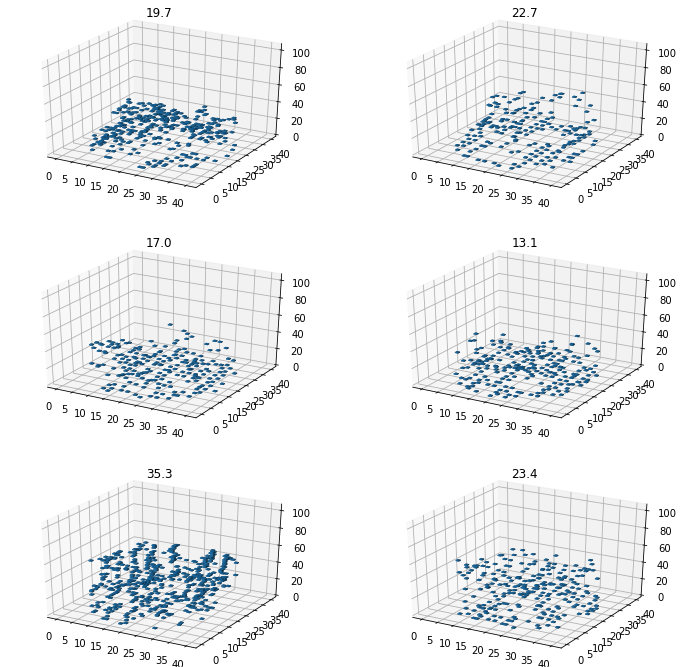

In [5]:
dls.show_batch()

# Learner

Set metrics to use

In [6]:
metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()]

Create learner

In [7]:
inc_learner = inception_learner(dls, path='.', metrics=metrics,  y_range=(0,dls.train.items[target_col].max() * 1.1))
inc_learner.to_fp16()

Search for a good learning rate

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.0012022644514217973)

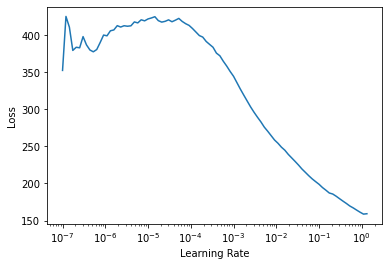

In [8]:
inc_learner.lr_find()

Fit with one cycle scheduling.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,350.784119,329.497009,18.152052,94.745903,-16.023432,-83.635422,16.052094,-3.400886,00:17
1,183.078506,81.883888,9.048971,47.231735,-4.632486,-24.179585,6.292402,-0.093672,00:15
2,104.629456,32.017025,5.658359,29.534201,-0.194760,-1.016565,4.386399,0.572369,00:15
3,67.720596,25.362492,5.036119,26.286375,0.628538,3.280699,3.898260,0.661249,00:15
4,50.462879,53.589874,7.320510,38.209915,2.462002,12.850591,5.009621,0.284233,00:15
5,40.660744,49.905796,7.064404,36.873146,-3.166201,-16.526211,4.615820,0.333439,00:15
6,34.049992,31.536619,5.615747,29.311785,2.536542,13.239657,4.133976,0.578785,00:15
7,28.883457,29.466356,5.428292,28.333351,3.060778,15.975945,4.215278,0.606436,00:15
8,25.321503,56.858948,7.540487,39.358101,-5.451153,-28.452677,5.722025,0.240570,00:15
9,24.346958,21.196348,4.603949,24.030634,1.540209,8.039228,3.318277,0.716894,00:15


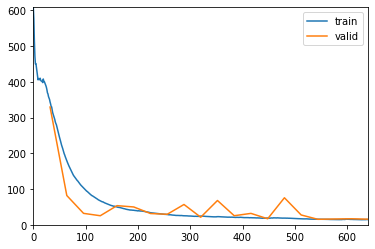

In [9]:
inc_learner.fit_one_cycle(20, lr_max=1e-3, cbs=ShowGraphCallback())

# See results

In [10]:
reg_interp = RegressionInterpretation.from_learner(inc_learner, ds_idx=1)

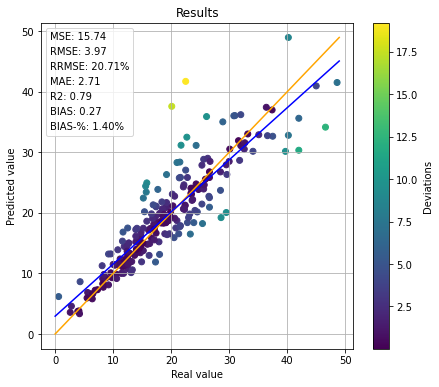

In [11]:
reg_interp.plot_results()
plt.show()

In [12]:
test_df = pd.read_csv(basedir/'AV.leaf.on.test.csv')

In [13]:
test_dl = inc_learner.dls.test_dl(test_df, with_labels=True)

In [14]:
test_interp = RegressionInterpretation.from_learner(inc_learner, dl=test_dl)

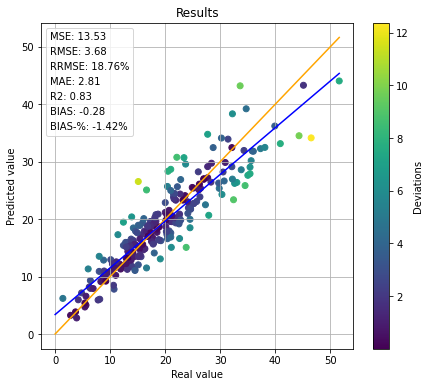

In [15]:
test_interp.plot_results()
plt.show()

In [47]:
inc_learner.export(f'models/{target_col}_voxels.pkl')

# Test that loading works

In [6]:
inc_learner = load_learner('models/h_voxels.pkl')

In [10]:
test_interp = RegressionInterpretation.from_learner(inc_learner, dl=test_dl)

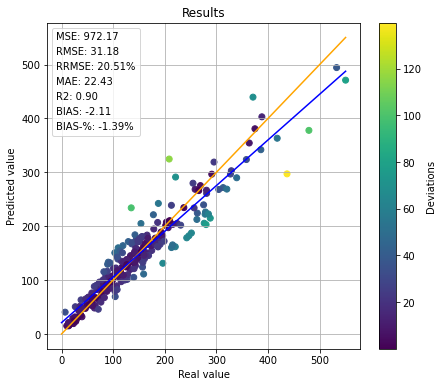

In [11]:
test_interp.plot_results()
plt.show()